<a href="https://colab.research.google.com/github/NREL/BEEAM/blob/flexlab-develop/FMU/flexlab_demo/notebooks/validation_NMBE_CVRMSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Purpose
Extracts observed and predicted CSV data, calculates NMBE and CV(RMSE), and loads plots.

In [ ]:
# connect to goolgle drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# import libraries
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

# 1 Setup

In [ ]:
# dir
dir = r'/content/drive/Shared drives/NREL DC Design Tool/Tasks/7 Validation/7.2 Whole Tool Validation/FLEXLAB'

# observed data dir and paths
obs_dir = dir + r'/FL_Data'
obs_elec_path = os.path.join(obs_dir, 'Raw/data_FL.csv')
obs_mech_path = os.path.join(obs_dir, 'Transformed/chw_fan_15min.csv')
obs_temp_path = os.path.join(obs_dir, 'Transformed/Strat Tree Data Export_average_15min.csv')

# predicted data dir
pre_dir = dir + r'/NREL OpenStudio Model/4 Validation'

# predicted data paths: AC experiment
ac_clg_path = os.path.join(pre_dir, 'AC_PTAC_Clg_Coil_Cooling_Rate.csv')
ac_fan_path = os.path.join(pre_dir, 'AC_PTAC_Fan_electric_rate.csv')
ac_plnm_temp_path = os.path.join(pre_dir, 'AC_PlnmB_zone_temp.csv')
ac_zone_temp_path = os.path.join(pre_dir, 'AC_ZoneB_zone_temp.csv')
ac_pwr_path = os.path.join(pre_dir, 'AC_Vin.P.csv')

# predicted data paths: DC experiment
dc_clg_path = os.path.join(pre_dir, 'DC_PTAC_Clg_Coil_Cooling_Rate.csv')
dc_fan_path = os.path.join(pre_dir, 'DC_PTAC_Fan_electric_rate.csv')
dc_plnm_temp_path = os.path.join(pre_dir, 'DC_PlnmB_zone_temp.csv')
dc_zone_temp_path = os.path.join(pre_dir, 'DC_ZoneB_zone_temp.csv')
dc_pwr_path = os.path.join(pre_dir, 'DC_Vin.P.csv')

# index column name
idx_col = 'datetime'

# column names
obs_col_name = 'Measured'
pre_col_name = 'Modeled'

# resample rule for raw data
resample_rule = '15T' 

# AC experiment beginning and end timestamps
ac_lo_beg = '2020-11-11 10:30'
ac_lo_end = '2020-11-11 17:00'
ac_md_beg = '2020-11-12 14:30'
ac_md_end = '2020-11-13 11:30'
ac_hi_beg = '2020-11-13 12:00'
ac_hi_end = '2020-11-16 08:00'
ac_beg = ac_lo_beg
ac_end = ac_hi_end

# DC experiment beginning and end timestamps
dc_hi_beg = '2020-11-17 18:00'
dc_hi_end = '2020-11-20 16:00'
dc_lo_beg = '2020-11-23 11:30'
dc_lo_end = '2020-11-25 08:45'
dc_md_beg = '2020-11-25 09:30'
dc_md_end = '2020-11-30 08:00'
dc_beg = dc_hi_beg
dc_end = dc_md_end

$ NMBE = \sum_{i=1}^n (y_i - \hat{y_i} ) / (n - p) * \bar{y} $

$ CV(RMSE) = \sqrt{ \sum{ (y_i - \hat{y_i})^2 } / (n - p) } / \bar{y} $

where

> $ y_i = $ single observed (measured) value
>
> $ \hat{y_i} = $ single predicted (modeled) value
>
> $ n = $ number of data points or periods
>
> $ p = $ number of parameters or terms in the
baseline model
>
> $ \bar{y} = $ arithmetic mean of the sample of n
observations


In [ ]:
# function for calcs
def calcs(pre_minus_obs_series, obs_series, pre_minus_obs_squared_series):

    # NMBE sum
    nmbe_sum = pre_minus_obs_series.sum()
    print(f'NMBE sum = {nmbe_sum}')

    # number of data points
    n = obs_series.count()
    print(f'n = {n}')

    # number of parameters
    p = 1

    # mean of samples
    y_bar = obs_series.mean()
    print(f'y_bar = {y_bar}')

    # calculate NMBE
    nmbe = nmbe_sum / ((n - p) * y_bar)
    nmbe_pct = nmbe * 100
    print(f'NMBE = {nmbe}')

    # sum of sqaures for CV(RMSE)
    cvrmse_sum = pre_minus_obs_squared_series.sum()
    # print(f'CV(RMSE) sum = {cvrmse_sum}')

    # calculate CV(RMSE)
    cvrmse = (cvrmse_sum / (n - p))**0.5 / y_bar
    cvrmse_pct = cvrmse * 100
    print(f'CV(RMSE) = {cvrmse}')

    return {'nmbe':nmbe_pct, 'cvrmse':cvrmse_pct}

# 2 Extract

In [ ]:
# raw data
# obs_df = pd.read_csv(obs_path)

# observed data: electrical
obs_elec_df = pd.read_csv(obs_elec_path)
obs_raw_elec_ac_df = pd.DataFrame(obs_elec_df.loc[:, obs_elec_df.columns[0:10]])
obs_raw_elec_dc_df = pd.DataFrame(data={'time':obs_elec_df['time'], 'DC_Power_Hub':obs_elec_df['DC_Power_Hub']})

# observed data: mechanical
obs_mech_df = pd.read_csv(obs_mech_path)
# obs_raw_mech_df = pd.DataFrame(data={'time':obs_df['time'], 'HVAC_Thermal_Load':obs_df['HVAC_Thermal_Load']})

# observed data: temperatures
obs_temp_df = pd.read_csv(obs_temp_path)

# predicted data: AC
pre_ac_clg_df = pd.read_csv(ac_clg_path)
pre_ac_fan_df = pd.read_csv(ac_fan_path)
pre_ac_plnm_temp_df = pd.read_csv(ac_plnm_temp_path)
pre_ac_zone_temp_df = pd.read_csv(ac_zone_temp_path)
pre_ac_pwr_df = pd.read_csv(ac_pwr_path)

# predicted data: DC
pre_dc_clg_df = pd.read_csv(dc_clg_path)
pre_dc_fan_df = pd.read_csv(dc_fan_path)
pre_dc_plnm_temp_df = pd.read_csv(dc_plnm_temp_path)
pre_dc_zone_temp_df = pd.read_csv(dc_zone_temp_path)
pre_dc_pwr_df = pd.read_csv(dc_pwr_path)

# lists for looping
raw_df_list = [obs_raw_elec_ac_df, obs_raw_elec_dc_df]

not_raw_df_list = [obs_mech_df, obs_temp_df,
                   pre_ac_clg_df, pre_ac_fan_df, pre_ac_plnm_temp_df, pre_ac_zone_temp_df, pre_ac_pwr_df,
                   pre_dc_clg_df, pre_dc_fan_df, pre_dc_plnm_temp_df, pre_dc_zone_temp_df, pre_dc_pwr_df]           

obs_raw_elec_ac_df, obs_temp_df

(                      time  ...  West_desk_plug_load_emulators
 0      2020-10-30 00:00:00  ...                      31.880844
 1      2020-10-30 00:01:00  ...                      31.878972
 2      2020-10-30 00:02:00  ...                      31.913479
 3      2020-10-30 00:03:00  ...                      31.973615
 4      2020-10-30 00:04:00  ...                      31.986319
 ...                    ...  ...                            ...
 46075  2020-11-30 23:55:00  ...                       0.364146
 46076  2020-11-30 23:56:00  ...                       0.368845
 46077  2020-11-30 23:57:00  ...                       0.331812
 46078  2020-11-30 23:58:00  ...                       0.353618
 46079  2020-11-30 23:59:00  ...                       0.342477
 
 [46080 rows x 10 columns],                  datetime  zone_temp  plnm_temp
 0     2020-10-30 00:00:00  25.642054  23.693248
 1     2020-10-30 00:15:00  25.685371  23.685806
 2     2020-10-30 00:30:00  25.733244  23.701334
 3     

# 3 Transform

In [ ]:
# loop through raw dataframes
for df in raw_df_list:
    
    # print columns
    [print(col) for col in df.columns]
    print('')

    # rename timestamp column
    df.rename(columns={'time':idx_col}, inplace=True)

    # convert timestamp
    df[idx_col] = pd.to_datetime(df[idx_col])

    # set index
    df.set_index(idx_col, inplace=True)

    # resample...doesn't work in a loop
    # df = df.resample(resample_rule).mean()

# show
obs_raw_elec_ac_df

time
AC_LED_Fixture_1
AC_LED_Fixture_2
AC_LED_Fixture_3
AC_LED_Fixture_4
AC_LED_Fixture_5
AC_LED_Fixture_6
North_desk_plug_load_emulators
East_desk_plug_load_emulators
West_desk_plug_load_emulators

time
DC_Power_Hub



,AC_LED_Fixture_1,AC_LED_Fixture_2,AC_LED_Fixture_3,AC_LED_Fixture_4,AC_LED_Fixture_5,AC_LED_Fixture_6,North_desk_plug_load_emulators,East_desk_plug_load_emulators,West_desk_plug_load_emulators
datetime,,,,,,,,,
2020-10-30 00:00:00,-0.022646,0.043686,-0.011733,0.068407,0.025879,0.067042,30.912129,31.659119,31.880844
2020-10-30 00:01:00,-0.020743,0.043564,-0.015013,0.068242,0.025999,0.066976,30.854053,31.657970,31.878972
2020-10-30 00:02:00,-0.021927,0.043721,-0.015699,0.068486,0.026037,0.067066,30.860608,31.671665,31.913479
2020-10-30 00:03:00,-0.021649,0.043709,-0.013002,0.068499,0.025963,0.066603,30.798140,31.609107,31.973615
2020-10-30 00:04:00,-0.015017,0.043448,-0.013531,0.068233,0.025754,0.066618,30.889659,31.680165,31.986319
...,...,...,...,...,...,...,...,...,...
2020-11-30 23:55:00,-0.023115,0.018217,-0.009511,-0.001031,0.000426,-0.001840,0.109180,0.069521,0.364146
2020-11-30 23:56:00,-0.027674,0.018347,-0.009034,-0.001115,0.000402,-0.001613,0.103267,0.071613,0.368845
2020-11-30 23:57:00,-0.026946,0.018073,-0.007427,-0.001130,0.000497,-0.001755,0.106598,0.068883,0.331812


In [ ]:
# loop through not raw dataframe list
for df in not_raw_df_list:
    
    # print columns
    [print(col) for col in df.columns]
    print('')

    # convert timestamp
    df[idx_col] = pd.to_datetime(df[idx_col])

    # set index
    df.set_index(idx_col, inplace=True)

# show
obs_mech_df

datetime
chw
fan
chw_fan

datetime
zone_temp
plnm_temp

datetime
PTAC_Clg_Coil_Cooling_Rate

datetime
PTAC_Fan_electric_rate

datetime
PlnmB_zone_temp

datetime
ZoneB_zone_temp

datetime
Vin.P

datetime
PTAC_Clg_Coil_Cooling_Rate

datetime
PTAC_Fan_electric_rate

datetime
PlnmB_zone_temp

datetime
ZoneB_zone_temp

datetime
Vin.P



,chw,fan,chw_fan
datetime,,,
2020-10-30 00:00:00,0.955713,28.580654,29.340906
2020-10-30 00:15:00,0.889596,28.659275,29.543152
2020-10-30 00:30:00,0.875262,28.707050,29.582312
2020-10-30 00:45:00,0.880616,28.644261,29.524877
2020-10-30 01:00:00,0.896955,28.716636,29.613591
...,...,...,...
2020-11-30 06:45:00,728.836817,515.387326,1244.224143
2020-11-30 07:00:00,694.658074,514.799159,1209.457233
2020-11-30 07:15:00,630.403077,514.791260,1145.194336


## 3.1 AC Experiment

### 3.1.1 Electrical Load

In [ ]:
# copy observed dataframe
ac_elec_calc_df = pd.DataFrame(obs_raw_elec_ac_df.resample(resample_rule).mean()[ac_beg:ac_end])

# sum rows
ac_elec_calc_df[obs_col_name] = ac_elec_calc_df[ac_elec_calc_df.columns[0:9]].sum(axis=1)

# add column from predicted dataframe
ac_elec_calc_df[pre_col_name] = - pre_ac_pwr_df['Vin.P']

# new dataframe for plots
ac_elec_plot_df = pd.DataFrame(ac_elec_calc_df.loc[:])

# drop columns
ac_elec_plot_df.drop(ac_elec_plot_df.columns[0:9], axis=1, inplace=True)

# set periods between experiments to NaN for calcs
ac_elec_calc_df.loc[ac_lo_end:ac_md_beg, obs_col_name] = np.nan
ac_elec_calc_df.loc[ac_md_end:ac_hi_beg, obs_col_name] = np.nan

# calculate difference of predicted and observed for NMBE
ac_elec_calc_df['pre_min_obs'] = ac_elec_calc_df[pre_col_name] - ac_elec_calc_df[obs_col_name]

# calculate the square of the difference for CV(RMSE)
ac_elec_calc_df['pre_min_obs_sq'] = ac_elec_calc_df['pre_min_obs']**2

# calculate NMBE and CV(RMSE)
ac_elec_dict = calcs(ac_elec_calc_df['pre_min_obs'], ac_elec_calc_df[obs_col_name], ac_elec_calc_df['pre_min_obs_sq'])

# show
ac_elec_calc_df

NMBE sum = 1437.6513478374086
n = 381
y_bar = 1720.935798719587
NMBE = 0.0021983928880087277
CV(RMSE) = 0.020691183926497013


,AC_LED_Fixture_1,AC_LED_Fixture_2,AC_LED_Fixture_3,AC_LED_Fixture_4,AC_LED_Fixture_5,AC_LED_Fixture_6,North_desk_plug_load_emulators,East_desk_plug_load_emulators,West_desk_plug_load_emulators,Measured,Modeled,pre_min_obs,pre_min_obs_sq
datetime,,,,,,,,,,,,,
2020-11-11 10:30:00,30.698090,31.453184,31.504830,30.986242,31.046649,31.656522,150.831604,150.462491,150.545218,639.184830,900.22327,261.038440,68141.067317
2020-11-11 10:45:00,30.941650,31.794680,31.819065,31.339723,31.446393,31.935990,150.740440,150.347150,150.496330,640.861422,570.97090,-69.890522,4884.685080
2020-11-11 11:00:00,31.029683,31.917789,31.873156,31.453634,31.497008,32.039726,150.793265,150.482263,150.530903,641.617426,572.93890,-68.678526,4716.739934
2020-11-11 11:15:00,31.035374,31.924794,31.872398,31.463088,31.497793,32.049607,150.777698,150.399732,150.487324,641.507809,573.48260,-68.025209,4627.428994
2020-11-11 11:30:00,31.032450,31.929389,31.878320,31.465970,31.497076,32.054311,150.741559,150.331894,150.489880,641.420849,573.51526,-67.905589,4611.168963
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-16 07:00:00,58.680685,58.620884,59.176221,58.593379,59.167695,58.980424,521.219190,521.725599,521.005645,1917.169722,1940.19270,23.022978,530.057536
2020-11-16 07:15:00,58.666677,58.604074,59.161513,58.581651,59.151454,58.973112,521.342430,521.680025,521.119761,1917.280698,1940.09120,22.810502,520.319010
2020-11-16 07:30:00,58.680012,58.618090,59.170604,58.594683,59.163370,58.985236,521.251936,521.679173,520.980638,1917.123741,1940.01420,22.890459,523.973110


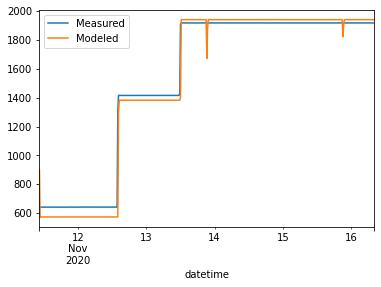

In [ ]:
ac_elec_plot_df.plot()

### 3.1.2 Cooling Load

In [ ]:
# copy observed dataframe
ac_clg_calc_df = pd.DataFrame(obs_mech_df.loc[ac_beg:ac_end, 'chw']) #.resample(resample_rule).mean()[ac_beg:ac_end])

# rename column
ac_clg_calc_df.rename(columns={'chw':obs_col_name}, inplace=True)

# reverse sign of observed cooling load
# ac_mech_calc_df[obs_col_name] = ac_mech_calc_df[obs_col_name]

# add column from predicted dataframes
ac_clg_calc_df[pre_col_name] = pre_ac_clg_df['PTAC_Clg_Coil_Cooling_Rate']

# new dataframe for plots
ac_clg_plot_df = pd.DataFrame(ac_clg_calc_df.loc[:])

# set periods between experiments to NaN for calcs
ac_clg_calc_df.loc[ac_lo_end:ac_md_beg, obs_col_name] = np.nan
ac_clg_calc_df.loc[ac_md_end:ac_hi_beg, obs_col_name] = np.nan

# calculate difference of predicted and observed for NMBE
ac_clg_calc_df['pre_min_obs'] = ac_clg_calc_df[pre_col_name] - ac_clg_calc_df[obs_col_name]

# calculate the square of the difference for CV(RMSE)
ac_clg_calc_df['pre_min_obs_sq'] = ac_clg_calc_df['pre_min_obs']**2

# calculate NMBE and CV(RMSE)
ac_clg_dict = calcs(ac_clg_calc_df['pre_min_obs'], ac_clg_calc_df[obs_col_name], ac_clg_calc_df['pre_min_obs_sq'])

# show
ac_clg_calc_df

NMBE sum = 99443.92513802001
n = 381
y_bar = 1816.3437712125458
NMBE = 0.1440776487273629
CV(RMSE) = 0.16088474332620292


,Measured,Modeled,pre_min_obs,pre_min_obs_sq
datetime,,,,
2020-11-11 10:30:00,823.578025,1090.47140,266.893375,71232.073445
2020-11-11 10:45:00,807.466571,737.99634,-69.470231,4826.112946
2020-11-11 11:00:00,849.196380,734.62580,-114.570580,13126.417858
2020-11-11 11:15:00,819.859551,745.15985,-74.699701,5580.045261
2020-11-11 11:30:00,824.332418,754.64680,-69.685618,4856.085362
...,...,...,...,...
2020-11-16 07:00:00,1964.662272,2308.50100,343.838728,118225.070689
2020-11-16 07:15:00,1967.515791,2311.49500,343.979209,118321.696408
2020-11-16 07:30:00,1861.386214,2314.51830,453.132086,205328.687604


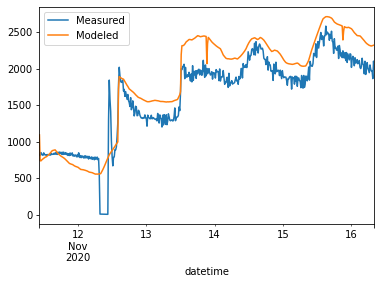

In [ ]:
ac_clg_plot_df.plot()

### 3.1.3 Temperatures

In [ ]:
# copy observed dataframe
ac_zone_calc_df = pd.DataFrame(obs_temp_df.loc[ac_beg:ac_end, 'zone_temp'])

# rename column
ac_zone_calc_df.rename(columns={'zone_temp':obs_col_name}, inplace=True)

# add column from predicted dataframe
ac_zone_calc_df[pre_col_name] = pre_ac_zone_temp_df['ZoneB_zone_temp']

# copy dataframe for plots
ac_zone_plot_df = pd.DataFrame(ac_zone_calc_df.loc[:])

# set periods between experiments to NaN for calcs
ac_zone_calc_df.loc[ac_lo_end:ac_md_beg, obs_col_name] = np.nan
ac_zone_calc_df.loc[ac_md_end:ac_hi_beg, obs_col_name] = np.nan

# calculate difference between predicted and observed for NMBE
ac_zone_calc_df['pre_min_obs'] = ac_zone_calc_df[pre_col_name] - ac_zone_calc_df[obs_col_name]

# calculate the square of the difference for CV(RMSE)
ac_zone_calc_df['pre_min_obs_sq'] = ac_zone_calc_df['pre_min_obs']**2

# calculate NMBE and CV(RMSE)
ac_zone_dict = calcs(ac_zone_calc_df['pre_min_obs'], ac_zone_calc_df[obs_col_name], ac_zone_calc_df['pre_min_obs_sq'])

# show
ac_zone_calc_df

NMBE sum = -141.17612782133307
n = 381
y_bar = 23.370591590082242
NMBE = -0.015896736050245015
CV(RMSE) = 0.016536774134294382


,Measured,Modeled,pre_min_obs,pre_min_obs_sq
datetime,,,,
2020-11-11 10:30:00,23.139306,22.999668,-0.139638,0.019499
2020-11-11 10:45:00,23.118969,23.000095,-0.118874,0.014131
2020-11-11 11:00:00,23.104780,23.000216,-0.104564,0.010934
2020-11-11 11:15:00,23.089950,23.000221,-0.089729,0.008051
2020-11-11 11:30:00,23.089258,23.000200,-0.089058,0.007931
...,...,...,...,...
2020-11-16 07:00:00,23.399835,23.000002,-0.399833,0.159867
2020-11-16 07:15:00,23.421530,23.000038,-0.421492,0.177655
2020-11-16 07:30:00,23.446750,23.000053,-0.446697,0.199538


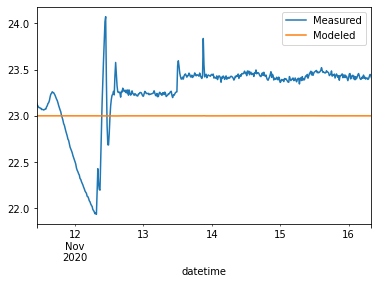

In [ ]:
ac_zone_plot_df.plot()

In [ ]:
# copy observed dataframe
ac_plnm_calc_df = pd.DataFrame(obs_temp_df.loc[ac_beg:ac_end, 'plnm_temp'])

# rename column
ac_plnm_calc_df.rename(columns={'plnm_temp':obs_col_name}, inplace=True)

# add column from predicted dataframe
ac_plnm_calc_df[pre_col_name] = pre_ac_plnm_temp_df['PlnmB_zone_temp']

# copy dataframe for plots
ac_plnm_plot_df = pd.DataFrame(ac_plnm_calc_df.loc[:])

# set periods between experiments to NaN for calcs
ac_plnm_calc_df.loc[ac_lo_end:ac_md_beg, obs_col_name] = np.nan
ac_plnm_calc_df.loc[ac_md_end:ac_hi_beg, obs_col_name] = np.nan

# calculate difference between predicted and observed for NMBE
ac_plnm_calc_df['pre_min_obs'] = ac_plnm_calc_df[pre_col_name] - ac_plnm_calc_df[obs_col_name]

# calculate the square of the difference for CV(RMSE)
ac_plnm_calc_df['pre_min_obs_sq'] = ac_plnm_calc_df['pre_min_obs']**2

# calculate NMBE and CV(RMSE)
ac_plnm_dict = calcs(ac_plnm_calc_df['pre_min_obs'], ac_plnm_calc_df[obs_col_name], ac_plnm_calc_df['pre_min_obs_sq'])

# show
ac_plnm_calc_df

NMBE sum = -566.3583384863331
n = 381
y_bar = 23.195086828048105
NMBE = -0.06425570601550591
CV(RMSE) = 0.06579389662697707


,Measured,Modeled,pre_min_obs,pre_min_obs_sq
datetime,,,,
2020-11-11 10:30:00,23.076363,20.967607,-2.108756,4.446850
2020-11-11 10:45:00,23.046211,20.998470,-2.047741,4.193241
2020-11-11 11:00:00,23.000329,21.008608,-1.991721,3.966954
2020-11-11 11:15:00,22.969693,21.024963,-1.944730,3.781975
2020-11-11 11:30:00,22.952131,21.052130,-1.900001,3.610002
...,...,...,...,...
2020-11-16 07:00:00,23.360472,21.753029,-1.607443,2.583874
2020-11-16 07:15:00,23.349245,21.742683,-1.606562,2.581041
2020-11-16 07:30:00,23.351945,21.735884,-1.616061,2.611654


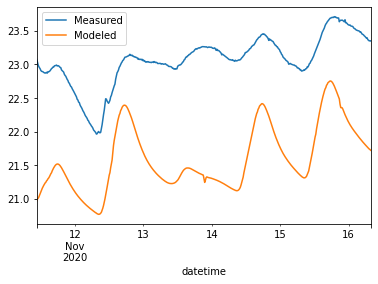

In [ ]:
ac_plnm_plot_df.plot()

### 3.1.4 Total Energy

In [ ]:
# series of total energy 
ac_obs_tot_series = ac_elec_calc_df.loc[:, obs_col_name] + obs_mech_df.loc[ac_beg:ac_end, 'chw_fan']
ac_pre_tot_series = ac_elec_calc_df.loc[:, pre_col_name] + ac_clg_calc_df.loc[:, pre_col_name] + pre_ac_fan_df.loc[:, 'PTAC_Fan_electric_rate']

# dict of data
ac_total_dict = {obs_col_name:ac_obs_tot_series,
                 pre_col_name:ac_pre_tot_series}

# dataframe
ac_total_calc_df = pd.DataFrame(data=ac_total_dict)

# copy dataframe for plots
ac_total_plot_df = pd.DataFrame(ac_total_calc_df.loc[:])

# set periods between experiments to NaN for calcs
ac_total_calc_df.loc[ac_lo_end:ac_md_beg, obs_col_name] = np.nan
ac_total_calc_df.loc[ac_md_end:ac_hi_beg, obs_col_name] = np.nan

# calculate difference between predicted and observed for NMBE
ac_total_calc_df['pre_min_obs'] = ac_total_calc_df[pre_col_name] - ac_total_calc_df[obs_col_name]

# calculate the square of the difference for CV(RMSE)
ac_total_calc_df['pre_min_obs_sq'] = ac_total_calc_df['pre_min_obs']**2

# calculate NMBE and CV(RMSE)
ac_total_dict = calcs(ac_total_calc_df['pre_min_obs'], ac_total_calc_df[obs_col_name], ac_total_calc_df['pre_min_obs_sq'])

# show
ac_total_calc_df

NMBE sum = 119937.1147216975
n = 381
y_bar = 4049.1496338800607
NMBE = 0.07794821497058049
CV(RMSE) = 0.08631600745303618


,Measured,Modeled,pre_min_obs,pre_min_obs_sq
datetime,,,,
2020-11-11 10:30:00,1971.592432,2552.57927,580.986838,337545.705733
2020-11-11 10:45:00,1956.838374,1870.85184,-85.986534,7393.684100
2020-11-11 11:00:00,1999.279577,1869.44930,-129.830277,16855.900931
2020-11-11 11:15:00,1969.931797,1880.52705,-89.404747,7993.208697
2020-11-11 11:30:00,1974.061305,1890.04666,-84.014645,7058.460495
...,...,...,...,...
2020-11-16 07:00:00,4392.095733,4810.57830,418.482567,175127.658706
2020-11-16 07:15:00,4395.252294,4813.47080,418.218506,174906.718606
2020-11-16 07:30:00,4288.550847,4816.41710,527.866253,278642.781151


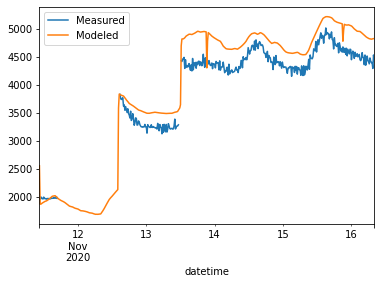

In [ ]:
ac_total_plot_df.plot()

## 3.2 DC Experiment

### 3.2.1 Electrical Load

In [ ]:
# copy observed dataframe
dc_elec_calc_df = pd.DataFrame(obs_raw_elec_dc_df.resample(resample_rule).mean()[dc_beg:dc_end])

# rename column
dc_elec_calc_df.rename(columns={'DC_Power_Hub':obs_col_name}, inplace=True)

# add column from predicted dataframe
dc_elec_calc_df[pre_col_name] = - pre_dc_pwr_df['Vin.P']

# new dataframe for plots
dc_elec_plot_df = pd.DataFrame(dc_elec_calc_df.loc[:])

# set periods between experiments to NaN for calcs
dc_elec_calc_df.loc[dc_hi_end:dc_lo_beg, obs_col_name] = np.nan
dc_elec_calc_df.loc[dc_lo_end:dc_md_beg, obs_col_name] = np.nan

# calculate difference of predicted and observed for NMBE
dc_elec_calc_df['pre_min_obs'] = dc_elec_calc_df[pre_col_name] - dc_elec_calc_df[obs_col_name]

# calculate the square of the difference for CV(RMSE)
dc_elec_calc_df['pre_min_obs_sq'] = dc_elec_calc_df['pre_min_obs']**2

# calculate NMBE and CV(RMSE)
dc_elec_dict = calcs(dc_elec_calc_df['pre_min_obs'], dc_elec_calc_df[obs_col_name], dc_elec_calc_df['pre_min_obs_sq'])

# show
dc_elec_calc_df

NMBE sum = -31389.650706683744
n = 933
y_bar = 650.8149902751161
NMBE = -0.051750318040855114
CV(RMSE) = 0.055724616448556974


,Measured,Modeled,pre_min_obs,pre_min_obs_sq
datetime,,,,
2020-11-17 18:00:00,835.247643,592.96344,-242.284203,58701.634920
2020-11-17 18:15:00,835.186981,791.08624,-44.100741,1944.875327
2020-11-17 18:30:00,835.289472,791.09700,-44.192472,1952.974616
2020-11-17 18:45:00,835.067624,791.12620,-43.941424,1930.848752
2020-11-17 19:00:00,835.036771,791.08970,-43.947071,1931.345028
...,...,...,...,...
2020-11-30 07:00:00,624.850747,595.77515,-29.075597,845.390350
2020-11-30 07:15:00,624.876262,595.75170,-29.124562,848.240134
2020-11-30 07:30:00,624.795827,595.76130,-29.034527,843.003755


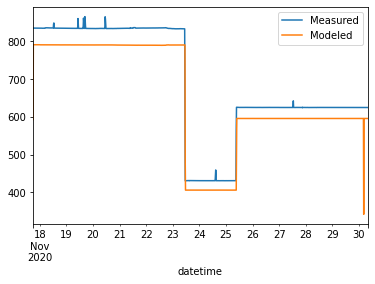

In [ ]:
dc_elec_plot_df.plot()

### 3.2.2 Cooling Load

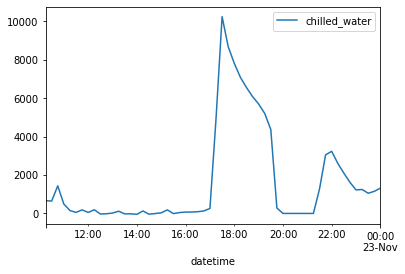

In [ ]:
obs_mech_df['2020-11-22 10:15':'2020-11-23 00:00'].plot()
# '2020-11-22 10:45' 

In [ ]:
# copy observed dataframe
dc_clg_calc_df = pd.DataFrame(obs_mech_df.loc[dc_beg:dc_end, 'chw'])

# rename column
dc_clg_calc_df.rename(columns={'chw':obs_col_name}, inplace=True)

# reverse sign of observed cooling load
# dc_mech_calc_df[obs_col_name] = - dc_mech_calc_df[obs_col_name]

# add column from predicted dataframes
dc_clg_calc_df[pre_col_name] = pre_dc_clg_df['PTAC_Clg_Coil_Cooling_Rate']

# set bad data to NaN
dc_clg_calc_df.loc['2020-11-22 10:15':'2020-11-23 00:00', obs_col_name] = np.nan #'2020-11-22 10:45':'2020-11-22 23:00'

# new dataframe for plots
dc_clg_plot_df = pd.DataFrame(dc_clg_calc_df)

# set periods between experiments to NaN for calcs
dc_clg_calc_df.loc[dc_hi_end:dc_lo_beg, obs_col_name] = np.nan
dc_clg_calc_df.loc[dc_lo_end:dc_md_beg, obs_col_name] = np.nan

# calculate difference of predicted and observed for NMBE
dc_clg_calc_df['pre_min_obs'] = dc_clg_calc_df[pre_col_name] - dc_clg_calc_df[obs_col_name]

# calculate the square of the difference for CV(RMSE)
dc_clg_calc_df['pre_min_obs_sq'] = dc_clg_calc_df['pre_min_obs']**2

# calculate NMBE and CV(RMSE)
dc_clg_dict = calcs(dc_clg_calc_df['pre_min_obs'], dc_clg_calc_df[obs_col_name], dc_clg_calc_df['pre_min_obs_sq'])

# show
dc_clg_calc_df

NMBE sum = 49071.156569266794
n = 933
y_bar = 904.1352583501964
NMBE = 0.05823404746154722
CV(RMSE) = 0.14208443055288156


,Measured,Modeled,pre_min_obs,pre_min_obs_sq
datetime,,,,
2020-11-17 18:00:00,980.819374,1055.14250,74.323126,5523.927011
2020-11-17 18:15:00,1112.145743,1497.02980,384.884057,148135.737636
2020-11-17 18:30:00,1151.807397,1480.50000,328.692603,108038.827096
2020-11-17 18:45:00,1119.484403,1455.57470,336.090297,112956.687697
2020-11-17 19:00:00,1053.963654,1437.92970,383.966046,147429.924686
...,...,...,...,...
2020-11-30 06:45:00,728.836817,749.12800,20.291183,411.732109
2020-11-30 07:00:00,694.658074,746.27734,51.619266,2664.548610
2020-11-30 07:15:00,630.403077,732.87335,102.470273,10500.156933


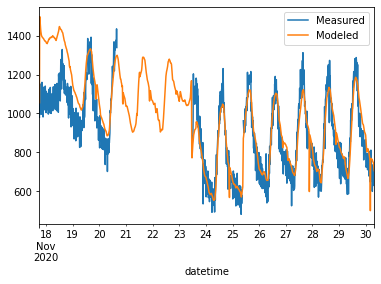

In [ ]:
dc_clg_plot_df.plot()

### 3.2.3 Temperatures

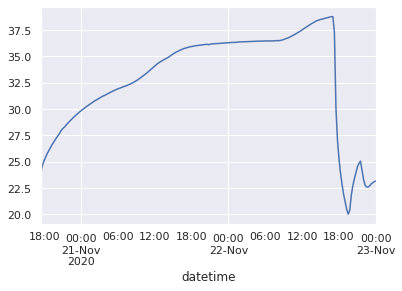

In [ ]:
obs_temp_df.loc['2020-11-20 17:30':'2020-11-23 00:00', 'zone_temp'].plot()

In [ ]:
# copy observed dataframe
dc_zone_calc_df = pd.DataFrame(obs_temp_df.loc[dc_beg:dc_end, 'zone_temp'])

# rename column
dc_zone_calc_df.rename(columns={'zone_temp':obs_col_name}, inplace=True)

# add column from predicted dataframe
dc_zone_calc_df[pre_col_name] = pre_dc_zone_temp_df['ZoneB_zone_temp']

# set bad data to NaN
dc_zone_calc_df.loc['2020-11-20 17:30':'2020-11-23 00:00', obs_col_name] = np.nan

# new dataframe for plots
dc_zone_plot_df = pd.DataFrame(dc_zone_calc_df.loc[:])

# set periods between experiments to NaN for calcs
dc_zone_calc_df.loc[dc_hi_end:dc_lo_beg, obs_col_name] = np.nan
dc_zone_calc_df.loc[dc_lo_end:dc_md_beg, obs_col_name] = np.nan

# calculate difference between predicted and observed for NMBE
dc_zone_calc_df['pre_min_obs'] = dc_zone_calc_df[pre_col_name] - dc_zone_calc_df[obs_col_name]

# calculate the square of the difference for CV(RMSE)
dc_zone_calc_df['pre_min_obs_sq'] = dc_zone_calc_df['pre_min_obs']**2

# calculate NMBE and CV(RMSE)
dc_zone_dict = calcs(dc_zone_calc_df['pre_min_obs'], dc_zone_calc_df[obs_col_name], dc_zone_calc_df['pre_min_obs_sq'])

# show
dc_zone_calc_df

NMBE sum = -145.6233749886662
n = 934
y_bar = 23.155967201272663
NMBE = -0.006740413233985948
CV(RMSE) = 0.007109753379437095


,Measured,Modeled,pre_min_obs,pre_min_obs_sq
datetime,,,,
2020-11-17 18:00:00,23.197808,23.000034,-0.197774,0.039114
2020-11-17 18:15:00,23.206877,22.998964,-0.207913,0.043228
2020-11-17 18:30:00,23.196386,22.998990,-0.197396,0.038965
2020-11-17 18:45:00,23.206489,22.999294,-0.207195,0.042930
2020-11-17 19:00:00,23.190290,22.999586,-0.190704,0.036368
...,...,...,...,...
2020-11-30 07:00:00,23.076906,22.999811,-0.077095,0.005944
2020-11-30 07:15:00,23.086813,22.999916,-0.086897,0.007551
2020-11-30 07:30:00,23.081688,23.000029,-0.081659,0.006668


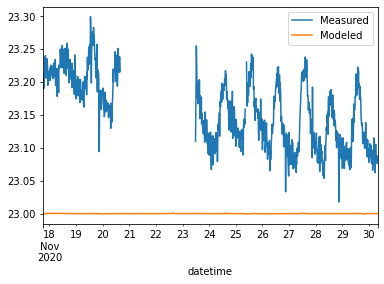

In [ ]:
dc_zone_plot_df.plot()

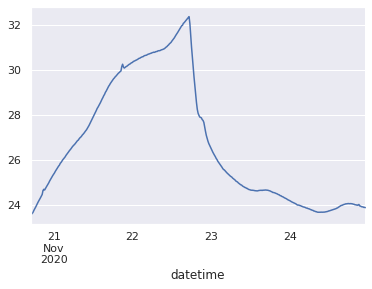

In [ ]:
obs_temp_df.loc['2020-11-20 17:00':'2020-11-24 23:00', 'plnm_temp'].plot()

In [ ]:
# copy observed dataframe
dc_plnm_calc_df = pd.DataFrame(obs_temp_df.loc[dc_beg:dc_end, 'plnm_temp'])

# rename column
dc_plnm_calc_df.rename(columns={'plnm_temp':obs_col_name}, inplace=True)

# add column from predicted dataframe
dc_plnm_calc_df[pre_col_name] = pre_dc_plnm_temp_df['PlnmB_zone_temp']

# set bad data to NaN
dc_plnm_calc_df.loc['2020-11-20 17:30':'2020-11-23 00:00', obs_col_name] = np.nan

# new dataframe for plots
dc_plnm_plot_df = pd.DataFrame(dc_plnm_calc_df.loc[:])

# set periods between experiments to NaN for calcs
dc_plnm_calc_df.loc[dc_hi_end:dc_lo_beg, obs_col_name] = np.nan
dc_plnm_calc_df.loc[dc_lo_end:dc_md_beg, obs_col_name] = np.nan

# calculate difference between predicted and observed for NMBE
dc_plnm_calc_df['pre_min_obs'] = dc_plnm_calc_df[pre_col_name] - dc_plnm_calc_df[obs_col_name]

# calculate the square of the difference for CV(RMSE)
dc_plnm_calc_df['pre_min_obs_sq'] = dc_plnm_calc_df['pre_min_obs']**2

# calculate NMBE and CV(RMSE)
dc_plnm_dict = calcs(dc_plnm_calc_df['pre_min_obs'], dc_plnm_calc_df[obs_col_name], dc_plnm_calc_df['pre_min_obs_sq'])

# show
dc_plnm_calc_df

NMBE sum = -1156.5947674370766
n = 934
y_bar = 23.568909096827735
NMBE = -0.052596893939859
CV(RMSE) = 0.055624175619088286


,Measured,Modeled,pre_min_obs,pre_min_obs_sq
datetime,,,,
2020-11-17 18:00:00,23.863505,22.551825,-1.311680,1.720504
2020-11-17 18:15:00,23.851711,22.537746,-1.313965,1.726503
2020-11-17 18:30:00,23.870643,22.551320,-1.319323,1.740612
2020-11-17 18:45:00,23.858746,22.559223,-1.299523,1.688761
2020-11-17 19:00:00,23.856464,22.553844,-1.302620,1.696818
...,...,...,...,...
2020-11-30 07:00:00,23.126625,21.846367,-1.280258,1.639061
2020-11-30 07:15:00,23.128189,21.834858,-1.293331,1.672706
2020-11-30 07:30:00,23.110097,21.823236,-1.286861,1.656012


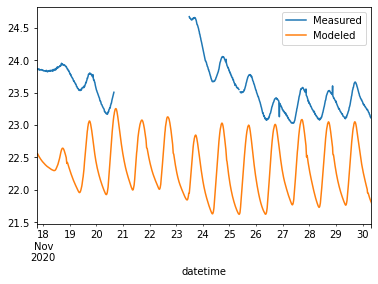

In [ ]:
dc_plnm_plot_df.plot()

### 3.2.4 Total Energy

In [ ]:
# series of total energy 
dc_obs_tot_series = dc_elec_calc_df.loc[:, obs_col_name] + obs_mech_df.loc[dc_beg:dc_end, 'chw_fan']
dc_pre_tot_series = dc_elec_calc_df.loc[:, pre_col_name] + dc_clg_calc_df.loc[:, pre_col_name] + pre_dc_fan_df.loc[:, 'PTAC_Fan_electric_rate']

# dict of data
dc_total_dict = {obs_col_name:dc_obs_tot_series,
                 pre_col_name:dc_pre_tot_series}

# dataframe
dc_total_calc_df = pd.DataFrame(data=dc_total_dict)

# set bad data to NaN
dc_total_calc_df.loc['2020-11-22 10:15':'2020-11-23 00:00', obs_col_name] = np.nan #'2020-11-22 10:45':'2020-11-22 23:00'

# copy dataframe for plots
dc_total_plot_df = pd.DataFrame(dc_total_calc_df.loc[:])

# calculate difference between predicted and observed for NMBE
dc_total_calc_df['pre_min_obs'] = dc_total_calc_df[pre_col_name] - dc_total_calc_df[obs_col_name]

# calculate the square of the difference for CV(RMSE)
dc_total_calc_df['pre_min_obs_sq'] = dc_total_calc_df['pre_min_obs']**2

# calculate NMBE and CV(RMSE)
dc_total_dict = calcs(dc_total_calc_df['pre_min_obs'], dc_total_calc_df[obs_col_name], dc_total_calc_df['pre_min_obs_sq'])

# show
dc_total_calc_df

NMBE sum = 62504.255345309546
n = 932
y_bar = 2068.8073785779925
NMBE = 0.03245187900277242
CV(RMSE) = 0.06413494390000296


,Measured,Modeled,pre_min_obs,pre_min_obs_sq
datetime,,,,
2020-11-17 18:00:00,2325.788246,2209.99054,-115.797706,13409.108675
2020-11-17 18:15:00,2456.737008,2850.00064,393.263632,154656.284588
2020-11-17 18:30:00,2495.995317,2833.48160,337.486283,113896.991320
2020-11-17 18:45:00,2463.337965,2808.58550,345.247535,119195.860763
2020-11-17 19:00:00,2398.378476,2790.90400,392.525524,154076.287076
...,...,...,...,...
2020-11-30 07:00:00,1834.307980,1903.93709,69.629110,4848.212914
2020-11-30 07:15:00,1770.070599,1890.50965,120.439051,14505.565057
2020-11-30 07:30:00,1782.205801,1876.47134,94.265539,8885.991876


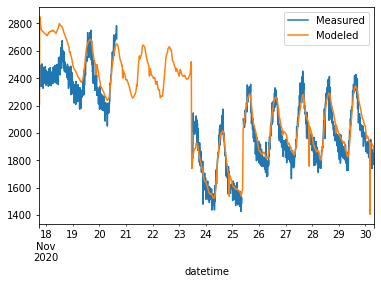

In [ ]:
dc_total_plot_df.plot()

# 4 Load

In [ ]:
# use Seaborn's default theme
sns.set_theme()

# titles
elec_title = 'Electrical Load'
clg_title = 'Cooling Load'
zone_title = 'Zone Temperature'
plnm_title = 'Plenum Temperature'
total_tile = 'Total Power'

# labels
power_label = 'Power (W)'
temp_label = 'Temperature (C)'
total_label = power_label

# plot observed and predicted colors
obs_clr = 'orange'
pre_clr = 'purple'

figsize = (10, 10)
annotation_fontsize = 10

## 4.1 AC Experiment

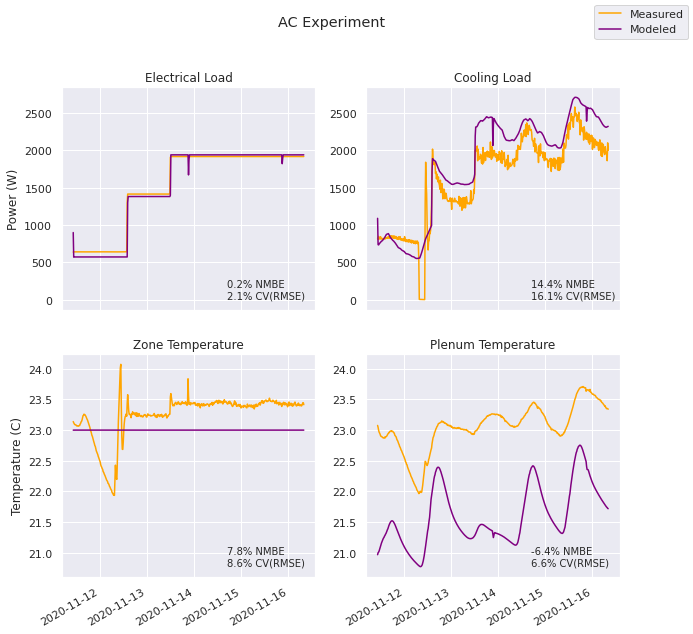

In [ ]:
# figure and axes
# ac_fig, ((ac_ax1, ac_ax2), (ac_ax3, ac_ax4)) = plt.subplots(ncols=2, nrows=2, sharex=True)

# figure
ac_fig = plt.figure(figsize=figsize)

# title
ac_fig.suptitle('AC Experiment')

# axis 1: electrical load
ac_ax1 = plt.subplot(2, 2, 1) #2grid((2,2), (0,0),)
ac_ax1.plot(ac_elec_plot_df.index, ac_elec_plot_df[obs_col_name], label=obs_col_name, color=obs_clr)
ac_ax1.plot(ac_elec_plot_df.index, ac_elec_plot_df[pre_col_name], label=pre_col_name, color=pre_clr)
ac_ax1.set_title(elec_title)
ac_ax1.set_ylabel(power_label)
ac_elec_nmbe = ac_elec_dict['nmbe']
ac_elec_cvrmse = ac_elec_dict['cvrmse']
ac_elec_text = f'{ac_elec_nmbe:.1f}% NMBE\n{ac_elec_cvrmse:.1f}% CV(RMSE)'
ac_ax1.annotate(s=ac_elec_text, xy=(0.65, 0.05), xycoords='axes fraction', fontsize=annotation_fontsize)

# axis 2: cooling load
ac_ax2 = plt.subplot(2, 2, 2, sharey=ac_ax1) #2grid((2,2), (0,1),)
ac_ax2.plot(ac_clg_plot_df.index, ac_clg_plot_df[obs_col_name], label=obs_col_name, color=obs_clr)
ac_ax2.plot(ac_clg_plot_df.index, ac_clg_plot_df[pre_col_name], label=pre_col_name, color=pre_clr)
ac_ax2.set_title(clg_title)
ac_clg_nmbe = ac_clg_dict['nmbe']
ac_clg_cvrmse = ac_clg_dict['cvrmse']
ac_clg_text = f'{ac_clg_nmbe:.1f}% NMBE\n{ac_clg_cvrmse:.1f}% CV(RMSE)'
ac_ax2.annotate(s=ac_clg_text, xy=(0.65, 0.05), xycoords='axes fraction', fontsize=annotation_fontsize)

# axis 3: zone temperature
ac_ax3 = plt.subplot(2, 2, 3) #2grid((2,2), (1,0),)
ac_ax3.plot(ac_zone_plot_df.index, ac_zone_plot_df[obs_col_name], label=obs_col_name, color=obs_clr)
ac_ax3.plot(ac_zone_plot_df.index, ac_zone_plot_df[pre_col_name], label=pre_col_name, color=pre_clr)
ac_ax3.set_title(zone_title)
ac_ax3.set_ylabel(temp_label)
ac_zone_nmbe = ac_zone_dict['nmbe']
ac_zone_cvrmse = ac_zone_dict['cvrmse']
ac_zone_text = f'{ac_zone_nmbe:.1f}% NMBE\n{ac_zone_cvrmse:.1f}% CV(RMSE)'
ac_ax3.annotate(s=ac_zone_text, xy=(0.65, 0.05), xycoords='axes fraction', fontsize=annotation_fontsize)

# axis 4: plenum temperature
ac_ax4 = plt.subplot(2, 2, 4, sharey=ac_ax3) #2grid((2,2), (1,1),)
ac_ax4.plot(ac_plnm_plot_df.index, ac_plnm_plot_df[obs_col_name], label=obs_col_name, color=obs_clr)
ac_ax4.plot(ac_plnm_plot_df.index, ac_plnm_plot_df[pre_col_name], label=pre_col_name, color=pre_clr)
ac_ax4.set_title(plnm_title)
ac_plnm_nmbe = ac_plnm_dict['nmbe']
ac_plnm_cvrmse = ac_plnm_dict['cvrmse']
ac_plnm_text = f'{ac_plnm_nmbe:.1f}% NMBE\n{ac_plnm_cvrmse:.1f}% CV(RMSE)'
ac_ax4.annotate(s=ac_plnm_text, xy=(0.65, 0.05), xycoords='axes fraction', fontsize=annotation_fontsize)

# format x-axis
ac_fig.autofmt_xdate()

# add legend
handles, labels = ac_ax4.get_legend_handles_labels()
ac_fig.legend(handles, labels, loc='upper right')

Text(0.75, 0.05, '7.8% NMBE\n8.6% CV(RMSE)')

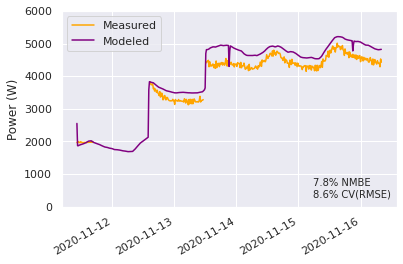

In [ ]:
# create figure and axis
ac_total_fig, ac_total_ax = plt.subplots()

# set title and axis labels
ac_total_ax.set_ylabel(total_label)

# add data
ac_total_ax.plot(ac_total_plot_df.index, ac_total_plot_df[obs_col_name], label=obs_col_name, color=obs_clr)
ac_total_ax.plot(ac_total_plot_df.index, ac_total_plot_df[pre_col_name], label=pre_col_name, color=pre_clr)

# add legend
ac_total_ax.legend(loc='upper left') #bbox_to_anchor=(1, 1), loc='center right') #loc='best')

# format x-axis
ac_total_ax.figure.autofmt_xdate()

# format y-axis
ac_total_ax.set_ylim(ymin=0, ymax=6000)

# annotaction
ac_total_nmbe = ac_total_dict['nmbe']
ac_total_cvrmse = ac_total_dict['cvrmse']
ac_total_text = f'{ac_total_nmbe:.1f}% NMBE\n{ac_total_cvrmse:.1f}% CV(RMSE)'
ac_total_ax.annotate(s=ac_total_text, xy=(0.75, 0.05), xycoords='axes fraction', fontsize=annotation_fontsize)

## 4.2 DC Experiment

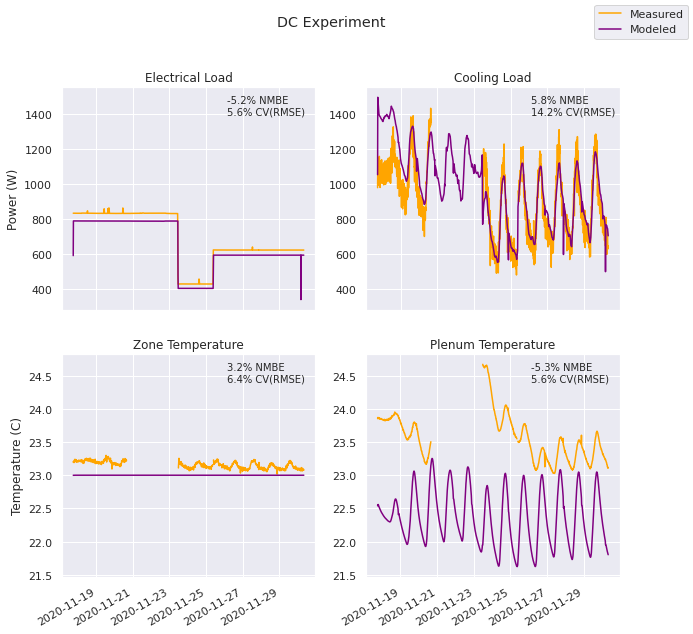

In [ ]:
# figure
dc_fig = plt.figure(figsize=figsize)

annotation_x = 0.65
annotation_y = 0.875

# title
dc_fig.suptitle('DC Experiment')

# axis 1: electrical load
dc_ax1 = plt.subplot(2, 2, 1) #2grid((2,2), (0,0),)
dc_ax1.plot(dc_elec_plot_df.index, dc_elec_plot_df[obs_col_name], label=obs_col_name, color=obs_clr)
dc_ax1.plot(dc_elec_plot_df.index, dc_elec_plot_df[pre_col_name], label=pre_col_name, color=pre_clr)
dc_ax1.set_title(elec_title)
dc_ax1.set_ylabel(power_label)
dc_elec_nmbe = dc_elec_dict['nmbe']
dc_elec_cvrmse = dc_elec_dict['cvrmse']
dc_elec_text = f'{dc_elec_nmbe:.1f}% NMBE\n{dc_elec_cvrmse:.1f}% CV(RMSE)'
dc_ax1.annotate(s=dc_elec_text, xy=(annotation_x, annotation_y), xycoords='axes fraction', fontsize=annotation_fontsize)

# axis 2: cooling load
dc_ax2 = plt.subplot(2, 2, 2, sharey=dc_ax1) #2grid((2,2), (0,1),)
dc_ax2.plot(dc_clg_plot_df.index, dc_clg_plot_df[obs_col_name], label=obs_col_name, color=obs_clr)
dc_ax2.plot(dc_clg_plot_df.index, dc_clg_plot_df[pre_col_name], label=pre_col_name, color=pre_clr)
dc_ax2.set_title(clg_title)
dc_clg_nmbe = dc_clg_dict['nmbe']
dc_clg_cvrmse = dc_clg_dict['cvrmse']
dc_clg_text = f'{dc_clg_nmbe:.1f}% NMBE\n{dc_clg_cvrmse:.1f}% CV(RMSE)'
dc_ax2.annotate(s=dc_clg_text, xy=(annotation_x, annotation_y), xycoords='axes fraction', fontsize=annotation_fontsize)

# axis 3: zone temperature
dc_ax3 = plt.subplot(2, 2, 3) #2grid((2,2), (1,0),)
dc_ax3.plot(dc_zone_plot_df.index, dc_zone_plot_df[obs_col_name], label=obs_col_name, color=obs_clr)
dc_ax3.plot(dc_zone_plot_df.index, dc_zone_plot_df[pre_col_name], label=pre_col_name, color=pre_clr)
dc_ax3.set_title(zone_title)
dc_ax3.set_ylabel(temp_label)
dc_zone_nmbe = dc_zone_dict['nmbe']
dc_zone_cvrmse = dc_zone_dict['cvrmse']
dc_zone_text = f'{dc_zone_nmbe:.1f}% NMBE\n{dc_zone_cvrmse:.1f}% CV(RMSE)'
dc_ax3.annotate(s=dc_zone_text, xy=(annotation_x, annotation_y), xycoords='axes fraction', fontsize=annotation_fontsize)

# axis 4: plenum temperature
dc_ax4 = plt.subplot(2, 2, 4, sharey=dc_ax3) #2grid((2,2), (1,1),)
dc_ax4.plot(dc_plnm_plot_df.index, dc_plnm_plot_df[obs_col_name], label=obs_col_name, color=obs_clr)
dc_ax4.plot(dc_plnm_plot_df.index, dc_plnm_plot_df[pre_col_name], label=pre_col_name, color=pre_clr)
dc_ax4.set_title(plnm_title)
dc_plnm_nmbe = dc_plnm_dict['nmbe']
dc_plnm_cvrmse = dc_plnm_dict['cvrmse']
dc_plnm_text = f'{dc_plnm_nmbe:.1f}% NMBE\n{dc_plnm_cvrmse:.1f}% CV(RMSE)'
dc_ax4.annotate(s=dc_plnm_text, xy=(annotation_x, annotation_y), xycoords='axes fraction', fontsize=annotation_fontsize)

# format x-axis
dc_fig.autofmt_xdate()

# add legend
handles, labels = dc_ax4.get_legend_handles_labels()
dc_fig.legend(handles, labels, loc='upper right')

Text(0.75, 0.05, '3.2% NMBE\n6.4% CV(RMSE)')

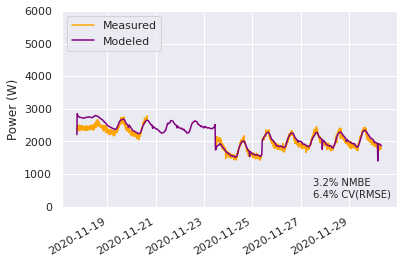

In [ ]:
# create figure and axis
dc_total_fig, dc_total_ax = plt.subplots()

# set title and axis labels
dc_total_ax.set_ylabel(total_label)

# add data
dc_total_ax.plot(dc_total_plot_df.index, dc_total_plot_df[obs_col_name], label=obs_col_name, color=obs_clr)
dc_total_ax.plot(dc_total_plot_df.index, dc_total_plot_df[pre_col_name], label=pre_col_name, color=pre_clr)

# add legend
dc_total_ax.legend(loc='upper left') #bbox_to_anchor=(1, 1), loc='center right') #loc='best')

# format x-axis
dc_total_ax.figure.autofmt_xdate()

# format y-axis
dc_total_ax.set_ylim(ymin=0, ymax=6000)

# annotaction
dc_total_nmbe = dc_total_dict['nmbe']
dc_total_cvrmse = dc_total_dict['cvrmse']
dc_total_text = f'{dc_total_nmbe:.1f}% NMBE\n{dc_total_cvrmse:.1f}% CV(RMSE)'
dc_total_ax.annotate(s=dc_total_text, xy=(0.75, 0.05), xycoords='axes fraction', fontsize=annotation_fontsize)

In [ ]:
# save
# ac_fig.savefig(os.path.join(pre_dir, 'ac_validation.png'), bbox_inches='tight', dpi=300)
ac_total_fig.savefig(os.path.join(pre_dir, 'ac_validation_total.png'), bbox_inches='tight', dpi=300)
# dc_fig.savefig(os.path.join(pre_dir, 'dc_validation.png'), bbox_inches='tight', dpi=300)
dc_total_fig.savefig(os.path.join(pre_dir, 'dc_validation_total.png'), bbox_inches='tight', dpi=300)